In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32

# Load datasets
train_df = pd.read_csv("../data/clean/train_cleaned.csv")
test_df = pd.read_csv("../data/clean/test_cleaned.csv")

# Build image paths
def get_image_path(image_name):
    return os.path.join("../data/raw/food-101/images", image_name + ".jpg")

train_df["image_path"] = train_df["image_name"].apply(get_image_path)
test_df["image_path"] = test_df["image_name"].apply(get_image_path)

# Label Encoding
label_encoder = LabelEncoder()
train_df["label_encoded"] = label_encoder.fit_transform(train_df["label"])
test_df["label_encoded"] = label_encoder.transform(test_df["label"])

# Save label map for inference
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label encoding complete. Example mapping:")
print(list(label_map.items())[:10])

# TF data pipeline
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df["image_path"], train_df["label_encoded"]))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_df["image_path"], test_df["label_encoded"]))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

Label encoding complete. Example mapping:
[('apple_pie', 0), ('baby_back_ribs', 1), ('baklava', 2), ('beef_carpaccio', 3), ('beef_tartare', 4), ('beet_salad', 5), ('beignets', 6), ('bibimbap', 7), ('bread_pudding', 8), ('breakfast_burrito', 9)]


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load pretrained base
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers

# Add classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(len(label_encoder.classes_), activation="softmax")(x)

model_mobilenet = Model(inputs=base_model.input, outputs=output)

model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_mobilenet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,611,877 (9.96 MB)

 Trainable params: 353,893 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

print("Data augmentation generator initialized.")

Data augmentation generator initialized.


Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 287s 120ms/step - accuracy: 0.2967 - loss: 3.2983 - val_accuracy: 0.0393 - val_loss: 4.6236 - learning_rate: 1.0000e-04
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 324s 137ms/step - accuracy: 0.3667 - loss: 2.4957 - val_accuracy: 0.0362 - val_loss: 6.1196 - learning_rate: 1.0000e-04
Epoch 3/5
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5169 - loss: 1.6867
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 294s 124ms/step - accuracy: 0.5170 - loss: 1.6866 - val_accuracy: 0.0603 - val_loss: 5.9284 - learning_rate: 1.0000e-04
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 300s 127ms/step - accuracy: 0.4891 - loss: 1.7388 - val_accuracy: 0.0883 - val_loss: 5.6010 - learning_rate: 5.0000e-05
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Model training complete and saved!


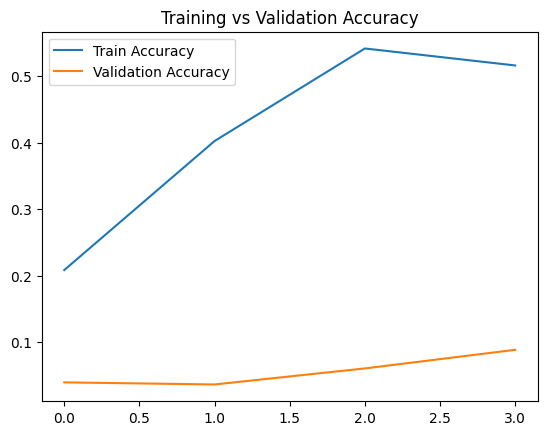

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Train model
history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[lr_scheduler, early_stop]
)

# Save model
model_mobilenet.save("../data/clean/mobilenet_food101.keras")
print("Model training complete and saved!")

# Plot training performance
import matplotlib.pyplot as plt
plt.plot(history_mobilenet.history["accuracy"], label="Train Accuracy")
plt.plot(history_mobilenet.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

Label: shrimp_and_grits


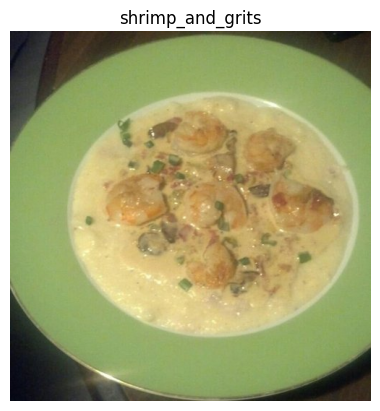

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image

sample = random.choice(train_df["image_path"].tolist())
label = train_df.loc[train_df["image_path"] == sample, "label"].values[0]
print("Label:", label)

plt.imshow(Image.open(sample))
plt.axis("off")
plt.title(label)
plt.show()

In [7]:
import numpy as np
from tensorflow.keras.preprocessing import image
from rapidfuzz import process
import pandas as pd

# Load USDA dataset
usda_df = pd.read_csv("../data/raw/usda_food_data.csv")

def find_closest_food(food_name, usda_df):
    descriptions = usda_df["description"].dropna().tolist()
    match = process.extractOne(food_name, descriptions)
    if match and match[1] > 70:
        return usda_df[usda_df["description"] == match[0]]
    return pd.DataFrame()

def predict_food(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model_mobilenet.predict(img_array)
    class_idx = np.argmax(preds)
    class_label = label_encoder.inverse_transform([class_idx])[0]
    confidence = np.max(preds) * 100

    print(f"Predicted food item: {class_label} ({confidence:.2f}% confidence)")

    nutrition = find_closest_food(class_label, usda_df)
    if not nutrition.empty:
        print("\nClosest match in USDA database:")
        print(nutrition.iloc[0][["description", "calories", "protein", "fat", "carbohydrates"]])
    else:
        print("No close nutrition data found for this food.")

    plt.imshow(img)
    plt.axis("off")
    plt.title(class_label)
    plt.show()

Testing on sample image:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Predicted food item: nachos (5.63% confidence)

Closest match in USDA database:
description      Nachos, chicken
calories                   242.0
protein                     11.2
fat                        13.33
carbohydrates              19.87
Name: 201, dtype: object


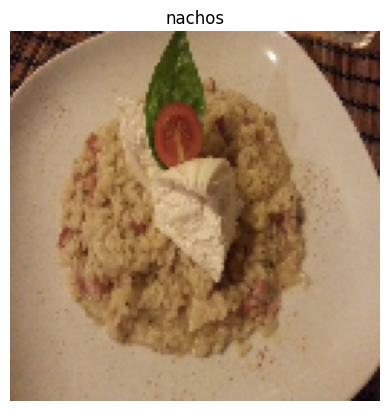

In [8]:
sample_test = random.choice(test_df["image_path"].tolist())
print("Testing on sample image:")
predict_food(sample_test)

In [11]:
# Fine-tuning last 30 layers of MobileNetV2

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with a smaller learning rate for fine-tuning
model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Fine-tuning last 30 layers of MobileNetV2...")
fine_tune_history = model_mobilenet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3
)

# Save fine-tuned model
model_mobilenet.save("../data/clean/mobilenet_food101_finetuned.keras")
print("Fine-tuned model saved successfully!")

Fine-tuning last 30 layers of MobileNetV2...
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 364s 152ms/step - accuracy: 0.0738 - loss: 4.1344 - val_accuracy: 0.1179 - val_loss: 4.2479
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 392s 165ms/step - accuracy: 0.1006 - loss: 4.0576 - val_accuracy: 0.1436 - val_loss: 4.0636
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 381s 161ms/step - accuracy: 0.1274 - loss: 3.8530 - val_accuracy: 0.1731 - val_loss: 3.8698
Fine-tuned model saved successfully!



Testing image: ../data/raw/food-101/images/chicken_wings/997781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
Predicted food item: seaweed_salad (3.66% confidence)
No close nutrition data found for this food.


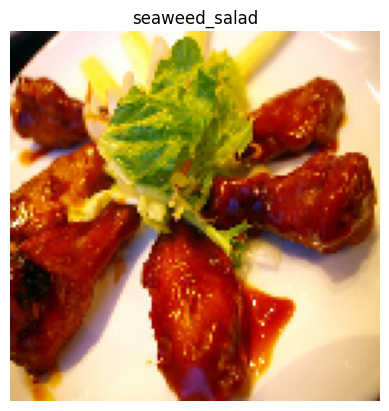


Testing image: ../data/raw/food-101/images/beef_tartare/3121750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted food item: tuna_tartare (2.46% confidence)

Closest match in USDA database:
description      Steak tartare
calories                 216.0
protein                  17.45
fat                       15.6
carbohydrates             0.34
Name: 10, dtype: object


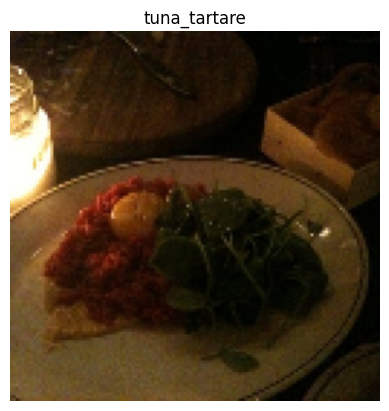


Testing image: ../data/raw/food-101/images/spaghetti_carbonara/1094002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted food item: spaghetti_carbonara (7.40% confidence)
No close nutrition data found for this food.


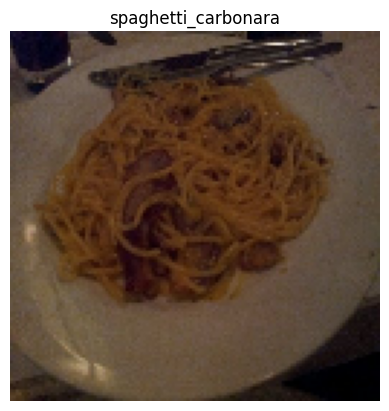


Testing image: ../data/raw/food-101/images/beet_salad/1510527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted food item: seaweed_salad (7.80% confidence)
No close nutrition data found for this food.


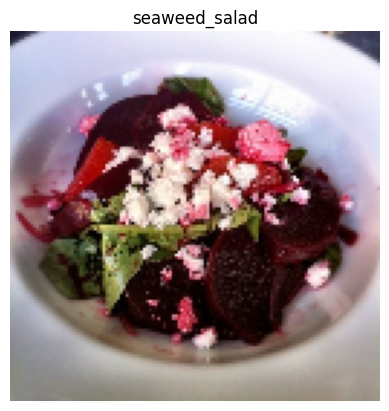


Testing image: ../data/raw/food-101/images/shrimp_and_grits/2534841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted food item: pizza (2.35% confidence)

Closest match in USDA database:
description      Pizza rolls
calories               345.0
protein                 9.19
fat                     10.5
carbohydrates          53.39
Name: 304, dtype: object


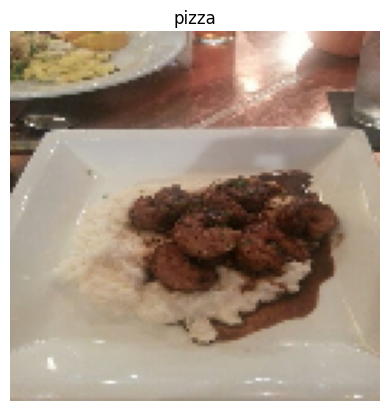

In [12]:
def test_multiple_predictions(num_samples=5):
    sample_paths = random.sample(test_df["image_path"].tolist(), num_samples)

    for path in sample_paths:
        print("\nTesting image:", path)
        predict_food(path)

# Test the model on 5 random images
test_multiple_predictions(num_samples=5)

In [13]:
# Evaluate final model performance
test_loss, test_acc = model_mobilenet.evaluate(test_ds)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accuracy: 0.1467 - loss: 3.9192

Final Test Accuracy: 0.1731
Final Test Loss: 3.8698


In [18]:
print("MODEL SUMMARY")

print(f"\nTotal classes trained: {len(label_encoder.classes_)}")
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

print("\nPerformance Summary:")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Total Parameters: {model_mobilenet.count_params():,}")

print("\nModel saved as: mobilenet_food101_finetuned.keras")
print("USDA data integrated for nutrition lookup.")
print("Ready for deployment or integration into CalTrackAI app.")

MODEL SUMMARY

Total classes trained: 101
Train samples: 75750
Test samples: 25250

Performance Summary:
Final Test Accuracy: 0.1731
Total Parameters: 2,611,877

Model saved as: mobilenet_food101_finetuned.keras
USDA data integrated for nutrition lookup.
Ready for deployment or integration into CalTrackAI app.
